In [1]:
import os
import re
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from zipfile import ZipFile

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
sess = tf.Session()
epochs = 30
batch_size = 250
max_sequence_length = 25
rnn_size = 10
embedding_size = 50
min_word_frequency = 1
learning_rate = 0.0005
dropout_keep_prob = tf.placeholder(tf.float32)

In [20]:
data_dir = 'temp'
data_file = 'text_data.txt'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
if not os.path.isfile(os.path.join(data_dir, data_file)):
        zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/' \
                  '00228/smsspamcollection.zip'
        r = requests.get(zip_url)
        z = ZipFile(io.BytesIO(r.content))
        file = z.read('SMSSpamCollection')
        
        # データの書式を設定
        text_data = file.decode()
        text_data = text_data.encode('ascii', errors='ignore') 
        text_data = text_data.decode().split('\n')
        # データをテキストファイルに保存
        with open(os.path.join(data_dir, data_file), 'w') as file_conn:
            for text in text_data:
                file_conn.write("{}\n".format(text))
else:
        # テキストファイルからデータを読み込む
        text_data = []
        with open(os.path.join(data_dir, data_file), 'r') as file_conn:
                    for row in file_conn:
                        text_data.append(row)
        text_data = text_data[:-1]
text_data = [x.split('\t') for x in text_data if len(x)>=1] 
[text_data_target, text_data_train] = [list(x) for x in zip(*text_data)]

In [38]:
def clean_text(text_string):
    text_string = re.sub(r'([^\s\w]|_|[0-9])+', '', text_string) 
    text_string = " ".join(text_string.split())
    text_string = text_string.lower()
    return(text_string)

# テキストをクリーニング
text_data_train = [clean_text(x) for x in text_data_train]

In [3]:
#ツイートのテキスト読み込み
test = open("RNN_tweet/extract_tweet.txt", "r", encoding="utf-8")
lines = test.readlines()
test.close()
print(len(lines))

10000


In [4]:
#ラベル読み込み
test = open("RNN_tweet/label.txt", "r", encoding="utf-8")
label = test.readlines()
test.close()
print(len(label))

10000


In [5]:
vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(
        max_sequence_length, min_frequency=min_word_frequency)
text_processed =  np.array(list(vocab_processor.fit_transform(lines)))

In [6]:
print(text_processed)

[[ 526 1492    5 ...    0    0    0]
 [ 902  866    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0   82 ... 6294 6295    0]
 [  70 1208    6 ...    0    0    0]
 [ 356 1092 3166 ...    0    0    0]]


In [7]:
text_processed = np.array(text_processed)
label = np.array(label)
#hamだったら1に変換
#text_data_target = np.array([1 if x=='ham' else 0 for x in text_data_target])
shuffled_ix = np.random.permutation(np.arange(len(label)))
x_shuffled = text_processed[shuffled_ix]
y_shuffled = label[shuffled_ix]

In [8]:
print(shuffled_ix)

[ 333 5378 3616 ... 6198 7528 2037]


In [9]:
ix_cutoff = int(len(y_shuffled)*0.80)
x_train, x_test = x_shuffled[:ix_cutoff], x_shuffled[ix_cutoff:]
y_train, y_test = y_shuffled[:ix_cutoff], y_shuffled[ix_cutoff:]
vocab_size = len(vocab_processor.vocabulary_)
print("Vocabulary Size: {:d}".format(vocab_size))
print("80-20 Train Test split: {:d} -- {:d}".format(len(y_train),len(y_test)))

Vocabulary Size: 10636
80-20 Train Test split: 8000 -- 2000


In [10]:
x_data = tf.placeholder(tf.int32, [None, max_sequence_length])
y_output = tf.placeholder(tf.int32, [None])

In [11]:
embedding_mat = tf.Variable(tf.random_uniform([vocab_size, embedding_size],-1.0, 1.0))
embedding_output = tf.nn.embedding_lookup(embedding_mat, x_data)

In [12]:
# RNNセルを定義
cell = tf.nn.rnn_cell.BasicLSTMCell(num_units = rnn_size)
        
output, state = tf.nn.dynamic_rnn(cell, embedding_output, dtype=tf.float32)
output = tf.nn.dropout(output, dropout_keep_prob)

In [14]:
# RNNシーケンスの出力を取得
output = tf.transpose(output, [1, 0, 2])
last = tf.gather(output, int(output.get_shape()[0]) - 1)

In [15]:
weight = tf.Variable(tf.truncated_normal([rnn_size, 2], stddev=0.1))
bias = tf.Variable(tf.constant(0.1, shape=[2]))
logits_out = tf.nn.softmax(tf.matmul(last, weight) + bias)

In [16]:
# logits=float32、labels=int32
losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_out, labels=y_output)
loss = tf.reduce_mean(losses)

In [17]:
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits_out, 1),tf.cast(y_output, tf.int64)),tf.float32))

In [18]:
class EarlyStopping():
    def __init__(self, patience = 0, verbose = 0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose
        
    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping')
                return True
        else:
            self._step = 0
            self._loss = loss
            
        return False

In [19]:
optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
train_step = optimizer.minimize(loss)

early_stopping = EarlyStopping(patience=10, verbose=1)

init = tf.global_variables_initializer()
sess.run(init)

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [20]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
# トレーニングを開始
for epoch in range(epochs):
    # トレーニングデータをシャッフル
    shuffled_ix = np.random.permutation(np.arange(len(x_train)))
    x_train = x_train[shuffled_ix]
    y_train = y_train[shuffled_ix]
    num_batches = int(len(x_train)/batch_size) + 1
    
    for i in range(num_batches):
        # トレーニングデータを選択
        min_ix = i * batch_size
        max_ix = np.min([len(x_train), ((i+1) * batch_size)])
        x_train_batch = x_train[min_ix:max_ix]
        y_train_batch = y_train[min_ix:max_ix]
        
        # トレーニングステップを実行
        train_dict = {x_data: x_train_batch,
                               y_output: y_train_batch,
                               dropout_keep_prob:0.5}
        sess.run(train_step, feed_dict=train_dict)
            
    # トレーニングの損失値と正解率を計算
    temp_train_loss, temp_train_acc = sess.run([loss, accuracy], feed_dict=train_dict)
    train_loss.append(temp_train_loss)
    train_accuracy.append(temp_train_acc)
    
    # 評価ステップを実行
    test_dict = {x_data: x_test, y_output: y_test, dropout_keep_prob:1.0}
    temp_test_loss, temp_test_acc = sess.run([loss, accuracy], feed_dict=test_dict)
    test_loss.append(temp_test_loss)
    test_accuracy.append(temp_test_acc)
    print('Epoch: {}, Test Loss: {:.2}, Test Acc: {:.2}'.format(epoch+1, temp_test_loss, temp_test_acc))

Epoch: 1, Test Loss: 0.69, Test Acc: 0.53
Epoch: 2, Test Loss: 0.69, Test Acc: 0.55
Epoch: 3, Test Loss: 0.68, Test Acc: 0.58
Epoch: 4, Test Loss: 0.67, Test Acc: 0.6
Epoch: 5, Test Loss: 0.66, Test Acc: 0.63
Epoch: 6, Test Loss: 0.65, Test Acc: 0.65
Epoch: 7, Test Loss: 0.65, Test Acc: 0.65
Epoch: 8, Test Loss: 0.63, Test Acc: 0.67
Epoch: 9, Test Loss: 0.63, Test Acc: 0.68
Epoch: 10, Test Loss: 0.64, Test Acc: 0.67
Epoch: 11, Test Loss: 0.61, Test Acc: 0.69
Epoch: 12, Test Loss: 0.62, Test Acc: 0.69
Epoch: 13, Test Loss: 0.61, Test Acc: 0.7
Epoch: 14, Test Loss: 0.61, Test Acc: 0.7
Epoch: 15, Test Loss: 0.61, Test Acc: 0.7
Epoch: 16, Test Loss: 0.6, Test Acc: 0.71
Epoch: 17, Test Loss: 0.6, Test Acc: 0.71
Epoch: 18, Test Loss: 0.61, Test Acc: 0.7
Epoch: 19, Test Loss: 0.59, Test Acc: 0.72
Epoch: 20, Test Loss: 0.59, Test Acc: 0.72
Epoch: 21, Test Loss: 0.59, Test Acc: 0.72
Epoch: 22, Test Loss: 0.6, Test Acc: 0.71
Epoch: 23, Test Loss: 0.59, Test Acc: 0.72
Epoch: 24, Test Loss: 0.59, 

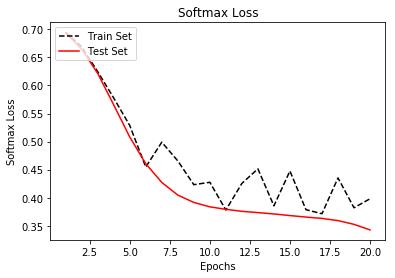

In [22]:
# 損失値をプロット simple RNN
epoch_seq = np.arange(1, epochs+1)
plt.plot(epoch_seq, train_loss, 'k--', label='Train Set')
plt.plot(epoch_seq, test_loss, 'r-', label='Test Set')
plt.title('Softmax Loss')
plt.xlabel('Epochs')
plt.ylabel('Softmax Loss')
plt.legend(loc='upper left')
plt.show()

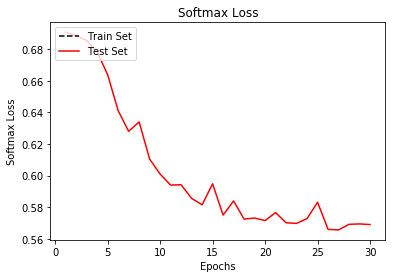

In [19]:
# 損失値をプロット LSTM
epoch_seq = np.arange(1, epochs+1)
plt.plot(epoch_seq, train_loss, 'k--', label='Train Set')
plt.plot(epoch_seq, test_loss, 'r-', label='Test Set')
plt.title('Softmax Loss')
plt.xlabel('Epochs')
plt.ylabel('Softmax Loss')
plt.legend(loc='upper left')
plt.show()

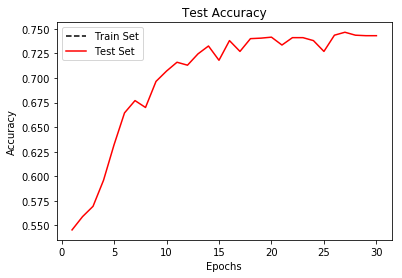

In [20]:
# 正解率をプロット simpleRNN
plt.plot(epoch_seq, train_accuracy, 'k--', label='Train Set')
plt.plot(epoch_seq, test_accuracy, 'r-', label='Test Set')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

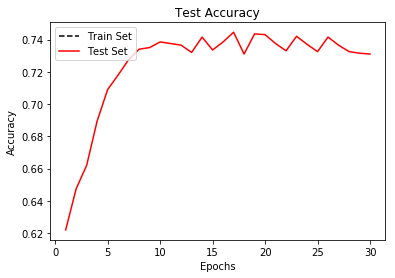

In [21]:
# 正解率をプロット LSTM
plt.plot(epoch_seq, train_accuracy, 'k--', label='Train Set')
plt.plot(epoch_seq, test_accuracy, 'r-', label='Test Set')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()